# Ensemble Learning and Random Forests

Suppose you pose a complex question to thousands of random people, then
aggregate their answers. In many cases you will find that this aggregated answer
is better than an expert’s answer. This is called the wisdom of the crowd.
Similarly, if you aggregate the predictions of a group of predictors (such as
classifiers or regressors), you will often get better predictions than with the best
individual predictor. A group of predictors is called an ensemble;

As an example of an Ensemble method, you can train a group of Decision Tree
classifiers, each on a different random subset of the training set. To make
predictions, you obtain the predictions of all the individual trees, then predict the
class that gets the most votes (see the last exercise in Chapter 6). Such an
ensemble of Decision Trees is called a Random Forest, and despite its simplicity,
this is one of the most powerful Machine Learning algorithms available today.

As discussed in Chapter 2, you will often use Ensemble methods near the end of
a project, once you have already built a few good predictors, to combine them
into an even better predictor. In fact, the winning solutions in Machine Learning
competitions often involve several Ensemble methods (most famously in the
Netflix Prize competition).

# Voting Classifiers

Suppose you have trained a few classifiers, each one achieving about 80%
accuracy. You may have a Logistic Regression classifier, an SVM classifier, a
Random Forest classifier, a K-Nearest Neighbors classifier, and perhaps a few
more (see Figure).

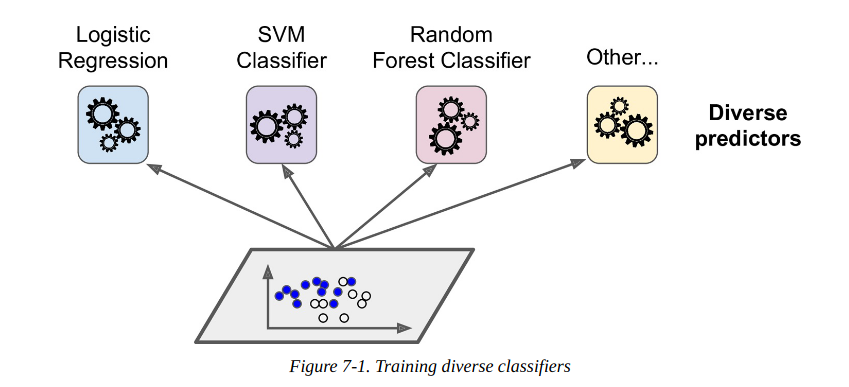

A very simple way to create an even better classifier is to aggregate the
predictions of each classifier and predict the class that gets the most votes. This
majority-vote classifier is called a hard voting classifier (see Figure).

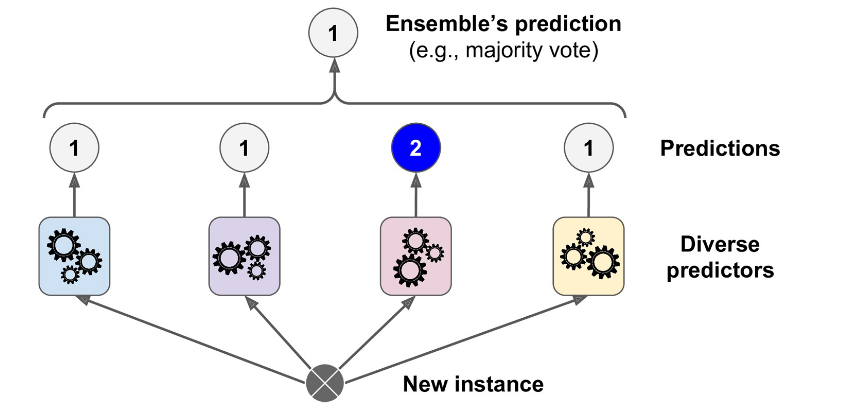

Somewhat surprisingly, this voting classifier often achieves a higher accuracy
than the best classifier in the ensemble. In fact, even if each classifier is a weak
learner (meaning it does only slightly better than random guessing), the
ensemble can still be a strong learner (achieving high accuracy), provided there
are a sufficient number of weak learners and they are sufficiently diverse.

How is this possible? The following analogy can help shed some light on this
mystery. Suppose you have a slightly biased coin that has a 51% chance of
coming up heads and 49% chance of coming up tails. If you toss it 1,000 times,
you will generally get more or less 510 heads and 490 tails, and hence a majority
of heads. If you do the math, you will find that the probability of obtaining a
majority of heads after 1,000 tosses is close to 75%. The more you toss the coin,
the higher the probability (e.g., with 10,000 tosses, the probability climbs over
97%). This is due to the law of large numbers: as you keep tossing the coin, the
ratio of heads gets closer and closer to the probability of heads (51%). Figure 7-3
shows 10 series of biased coin tosses. You can see that as the number of tosses
increases, the ratio of heads approaches 51%. Eventually all 10 series end up so
close to 51% that they are consistently above 50%.

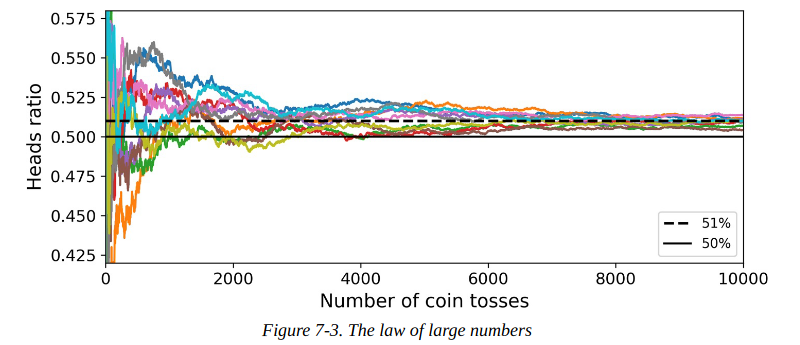

The following code creates and trains a voting classifier in Scikit-Learn,
composed of three diverse classifiers (the training set is the moons dataset,
introduced in Chapter 5)

In [2]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import VotingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC


# log_clf = LogisticRegression()
# rnd_clf = RandomForestClassifier()
# svm_clf = SVC()


# voting_clf = VotingClassifier(
#             estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
#             voting='hard')
# voting_clf.fit(X_train, y_train)

# from sklearn.metrics import accuracy_score

# for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
#     clf.fit(X_train1, y_train)
#     y_pred = clf.predict(X_test1)
#     print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


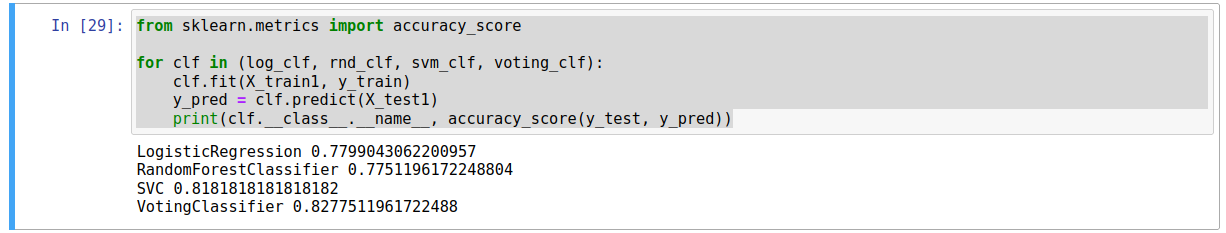

There you have it! The voting classifier slightly outperforms all the individual
classifiers.
If all classifiers are able to estimate class probabilities (i.e., they all have a
predict_proba() method), then you can tell Scikit-Learn to predict the class
with the highest class probability, averaged over all the individual classifiers.
This is called soft voting. It often achieves higher performance than hard voting
because it gives more weight to highly confident votes. All you need to do is
replace voting="hard" with voting="soft" and ensure that all classifiers can
estimate class probabilities. 

# Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training
algorithms, as just discussed. Another approach is to use the same training
algorithm for every predictor and train them on different random subsets of the
training set. When sampling is performed with replacement, this method is called
bagging  (short for bootstrap aggregating ). When sampling is performed
without replacement, it is called pasting.
In other words, both bagging and pasting allow training instances to be sampled
several times across multiple predictors, but only bagging allows training
instances to be sampled several times for the same predictor. This sampling and
training process is represented (in Figure).

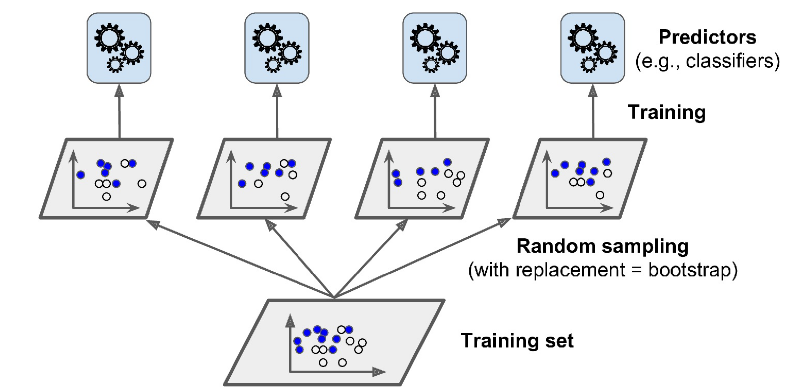

Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply aggregating the predictions of all predictors. The aggregation
function is typically the statistical mode (i.e., the most frequent prediction, just
like a hard voting classifier) for classification, or the average for regression.
Each individual predictor has a higher bias than if it were trained on the original
training set, but aggregation reduces both bias and variance.  Generally, the net
result is that the ensemble has a similar bias but a lower variance than a single
predictor trained on the original training set.


As you can see in Figure ABOVE, predictors can all be trained in parallel, via
different CPU cores or even different servers. Similarly, predictions can be made
in parallel. This is one of the reasons bagging and pasting are such popular
methods: they scale very well.

# Bagging and Pasting in Scikit-Learn

In [142]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_moons(n_samples=300, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split (X,y,test_size=0.25, stratify=y)

tree_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=500,
        max_samples=220, bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
tree_clf.fit(X_train, y_train)
# y_pred = bag_clf.predict(X_test)
bag_clf.score(X_test, y_test), tree_clf.score(X_test, y_test)

(0.9866666666666667, 0.9733333333333334)

The BaggingClassifier automatically performs soft voting instead of hard voting if the base
classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is
the case with Decision Tree classifiers.

Bootstrapping introduces a bit more diversity in the subsets that each predictor is
trained on, so bagging ends up with a slightly higher bias than pasting; but the
extra diversity also means that the predictors end up being less correlated, so the
ensemble’s variance is reduced. Overall, bagging often results in better models,
which explains why it is generally preferred. However, if you have spare time
and CPU power, you can use cross-validation to evaluate both bagging and
pasting and select the one that works best.

# Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given
predictor, while others may not be sampled at all. By default a
BaggingClassifier samples m training instances with replacement
(bootstrap=True), where m is the size of the training set. This means that only
about 63% of the training instances are sampled on average for each predictor.
The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances.
Note that they are not the same 37% for all predictors.
Since a predictor never sees the oob instances during training, it can be evaluated
on these instances, without the need for a separate validation set. You can
evaluate the ensemble itself by averaging out the oob evaluations of each
predictor.

In Scikit-Learn, you can set oob_score=True when creating a
BaggingClassifier to request an automatic oob evaluation after training. The
following code demonstrates this. The resulting evaluation score is available
through the oob_score_ variable:

In [132]:
from sklearn.metrics import accuracy_score


y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred), bag_clf.oob_score_

(1.0, 0.9866666666666667)

The oob decision function for each training instance is also available through the
oob_decision_function_ variable. In this case (since the base estimator has a
predict_proba() method), the decision function returns the class probabilities
for each training instance.

# Random Patches and Random Subspaces

The BaggingClassifier class supports sampling the features as well. Sampling
is controlled by two hyperparameters: max_features and
bootstrap_features. They work the same way as max_samples and
bootstrap, but for feature sampling instead of instance sampling. Thus, each
predictor will be trained on a random subset of the input features.
This technique is particularly useful when you are dealing with high-dimensional
inputs (such as images). Sampling both training instances and features is called
the Random Patches method.  Keeping all training instances (by setting
bootstrap=False and max_samples=1.0) but sampling features (by setting
bootstrap_features to True and/or max_features to a value smaller than
1.0) is called the Random Subspaces method.
Sampling features results in even more predictor diversity, trading a bit more
bias for a lower variance.

# Random Forests

As we have discussed, a Random Forest  is an ensemble of Decision Trees,
generally trained via the bagging method (or sometimes pasting), typically with
max_samples set to the size of the training set. Instead of building a
BaggingClassifier and passing it a DecisionTreeClassifier, you can
instead use the RandomForestClassifier class, which is more convenient and
optimized for Decision Trees  (similarly, there is a RandomForestRegressor
class for regression tasks). The following code uses all available CPU cores to
train a Random Forest classifier with 500 trees (each limited to maximum 16
nodes)

In [146]:
from sklearn.ensemble import RandomForestClassifier


rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

rnd_clf.score(X_test, y_test)

0.9733333333333334

With a few exceptions, a RandomForestClassifier has all the hyperparameters
of a DecisionTreeClassifier (to control how trees are grown), plus all the
hyperparameters of a BaggingClassifier to control the ensemble itself

The Random Forest algorithm introduces extra randomness when growing trees;
instead of searching for the very best feature when splitting a node (see
Chapter 6), it searches for the best feature among a random subset of features.
The algorithm results in greater tree diversity, which (again) trades a higher bias
for a lower variance, generally yielding an overall better model. The following
BaggingClassifier is roughly equivalent to the previous
RandomForestClassifier:

In [147]:
bag_clf = BaggingClassifier(
DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

# Extra-Trees

When you are growing a tree in a Random Forest, at each node only a random
subset of the features is considered for splitting (as discussed earlier). It is
possible to make trees even more random by also using random thresholds for
each feature rather than searching for the best possible thresholds (like regular
Decision Trees do)

A forest of such extremely random trees is called an Extremely Randomized
Trees ensemble  (or Extra-Trees for short). Once again, this technique trades
more bias for a lower variance. It also makes Extra-Trees much faster to train
than regular Random Forests, because finding the best possible threshold for
each feature at every node is one of the most time-consuming tasks of growing a
tree

You can create an Extra-Trees classifier using Scikit-Learn’s
ExtraTreesClassifier class. Its API is identical to the
RandomForestClassifier class. Similarly, the ExtraTreesRegressor class
has the same API as the RandomForestRegressor class.

### TIP

It is hard to tell in advance whether a RandomForestClassifier will perform better or worse
than an ExtraTreesClassifier. Generally, the only way to know is to try both and compare
them using cross-validation (tuning the hyperparameters using grid search).

# Feature Importance

Yet another great quality of Random Forests is that they make it easy to measure
the relative importance of each feature. Scikit-Learn measures a feature’s
importance by looking at how much the tree nodes that use that feature reduce
impurity on average (across all trees in the forest). More precisely, it is a
weighted average, where each node’s weight is equal to the number of training
samples that are associated with it

Scikit-Learn computes this score automatically for each feature after training,
then it scales the results so that the sum of all importances is equal to 1. You can
access the result using the feature_importances_ variable. For example, the
following code trains a RandomForestClassifier on the iris dataset and outputs each feature’s importance. 

In [149]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09428200459146654
sepal width (cm) 0.022736546131880753
petal length (cm) 0.4407862480704803
petal width (cm) 0.44219520120617245


Random Forests are very handy to get a quick understanding of what features
actually matter, in particular if you need to perform feature selection.